---
---
---
# RECURRENT NEURAL NETWORKS (RNN)
---
---
---

---
---
# RNN APPLICATION: PASSENGER NUMBER ESTIMATION
---
---

---
1-) Business Problem (İş Problemi)

2-) Data Understanding (Veriyi Anlamak)

3-) Data Preparation (Veriyi Hazırlamak)

4-) Modelling (Modelleme)

5-) Evalation (Değerlendirme)

6-) Using it to Predict (Tahmin İçin Kullanılması)

---

1-) Business Problem (İş Problemi)

Amaç; geçmiş yıllarda havayolunu kullanan yolcu bilgilerini kullanarak gelecek yılları tahmin etmek.

Aylık yolcu sayıları verilmiştir.

---

* Month: aylık olarak yer alan tarih değişkenidir.
* Passengers: İlgili işlem tarihindeki aylık yolcu sayısı.

2-) Data Understanding (Veriyi Anlamak)

2.1-) Data Understanding (Veriyi Anlamak)

![](CNN_Story_Of_The_Dataset.png)

In [118]:
# GEREKLİ KÜTÜPHANELER

# Veriyi Okuma ve işleme için;
import numpy             as np
import pandas            as pd
import datetime          as dt
import tensorflow        as tf
import matplotlib.pyplot as plt
import random

# Model Değerlendirme için;
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error

# Model için;

from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping

# Warning kapatmak için;
import warnings
warnings.filterwarnings("ignore")

# Tensorflow Warning Engelleme için;
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.2-) Veri Setinin Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [119]:
df = pd.read_csv("international-airline-passengers.csv")

In [120]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [121]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [122]:
df.columns = ["Month","Passengers"]

In [123]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [124]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [125]:
df.shape

(145, 2)

In [126]:
df.size

290

In [127]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [128]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [129]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

3-)Data Preparation (Veriyi Hazırlamak)

In [130]:
df = df[:144]

In [131]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [133]:
df["Month"] = pd.to_datetime(df["Month"])

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [135]:
print("Min Tarih:", df["Month"].min())
print("Max Tarih:", df["Month"].max())

Min Tarih: 1949-01-01 00:00:00
Max Tarih: 1960-12-01 00:00:00


In [136]:
df.index = df["Month"]

In [137]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [138]:
df.drop("Month",axis=1,inplace=True)

In [139]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [140]:
result_df = df.copy()

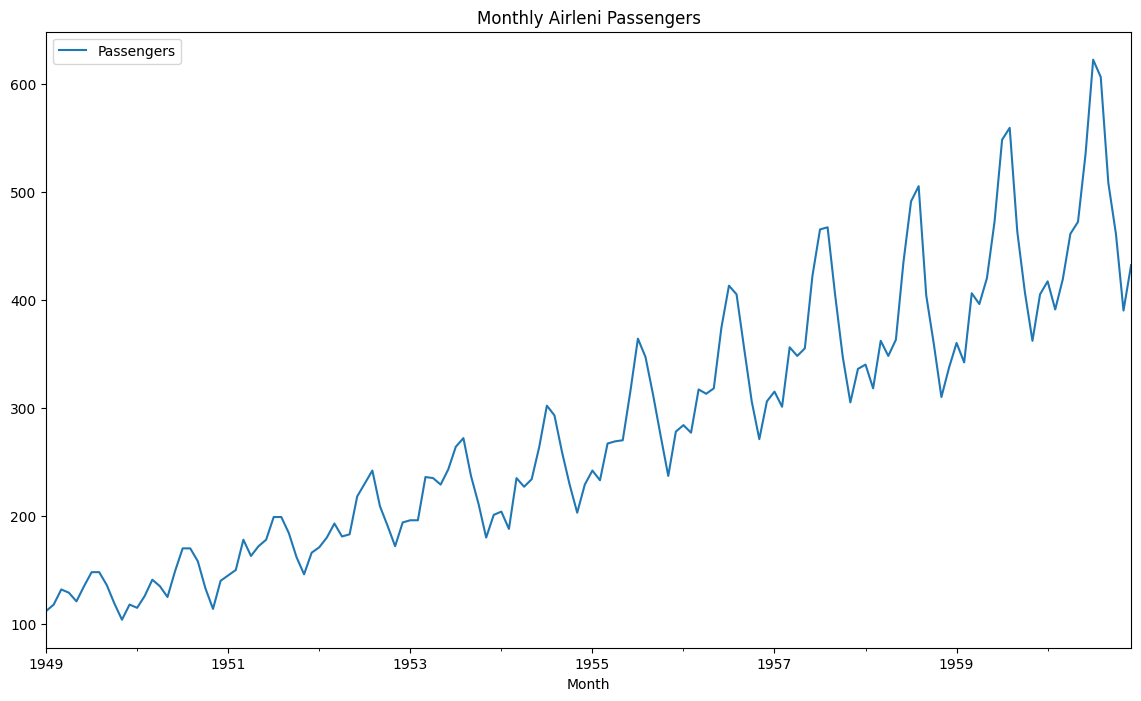

In [141]:
df.plot(figsize=(14,8),title="Monthly Airleni Passengers");

In [142]:
#veriyi numpy array yapma
data = df["Passengers"].values

In [143]:
data[:5]

array([112., 118., 132., 129., 121.])

In [144]:
type(data[:5])

numpy.ndarray

In [145]:
type(data[0])

numpy.float64

In [146]:
# Float16 is a good choice for memory-constrained systems, 
# Float32 is a good balance between accuracy and performance, and 
# Float64 is suitable for high-precision applications.
data = data.astype("float32")

In [147]:
type(data[0])

numpy.float32

In [148]:
data.shape

(144,)

In [149]:
data = data.reshape(-1,1)

In [150]:
data.shape

(144, 1)

2.3-) Train-Test Split

scikit-learn'in train-test split fonksiyonu rastgele ayırır.

Zaman serisinde fazla işe yaramaz.

In [151]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe)*(1-test_size)))
    train    = dataframe[:position]
    test     = dataframe[position:]
    return train,test,position

In [152]:
train,test,position = split_data(data,0.33) #0.33 test, 0.67 train

In [153]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [154]:
#standartlaştırma
scaler_train = MinMaxScaler(feature_range=(0,1))
train        = scaler_train.fit_transform(train)
scaler_test  = MinMaxScaler(feature_range=(0,1))
test         = scaler_test.fit_transform(test)

In [155]:
train[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [156]:
test[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [157]:
# zaman serilerinde veri en çok kendisinden bir önceki veriden etkilenir 
# varsayımı kabul edilmiştir. Bunu da veri setine eklersek;
def create_features(data, lookback):
    X,Y=[],[]
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [158]:
lookback=1

In [159]:
#Train için;
X_train, y_train = create_features(train,lookback)
#Test için;
X_test, y_test =  create_features(test,lookback)

In [160]:
print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [161]:
# RNN için 3 boyutlu veri seti lazım
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [162]:
print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


4-) Modelling (Modelleme)